In [15]:
import numpy as np
import torch
import torch.nn as nn
import  matplotlib.pyplot as plt

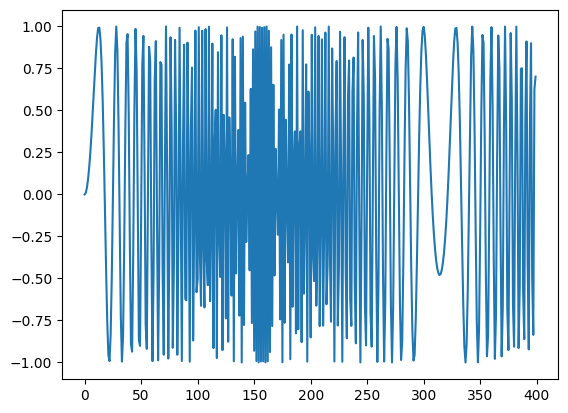

In [16]:
N = 1000

# series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1
series = np.sin((0.1*np.arange(400))**2)

plt.plot(series)
plt.show()

In [17]:
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t : t + T]
    X.append(x)
    
    y = series[t + T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)

N = len(X)
print(f"x.shape: {X.shape}, y.shape: {Y.shape}") 

x.shape: (390, 10, 1), y.shape: (390, 1)


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.GRU(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            # nonlinearity='relu',
            batch_first=True
        )
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        # out is of size (N, T, M)
        out, _ = self.rnn(X, h0)
        out = self.fc(out[:, -1, :])
        return out

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

SimpleRNN(
  (rnn): GRU(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [22]:
x_train = torch.from_numpy(X[: -N // 2].astype(np.float32))
y_train = torch.from_numpy(Y[: -N // 2].astype(np.float32))
x_test = torch.from_numpy(X[-N // 2 :].astype(np.float32))
y_test = torch.from_numpy(Y[-N // 2 :].astype(np.float32))

In [23]:
# move data to gpu
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

In [24]:
def full_gd(model, 
            criterion, 
            optimizer, 
            x_train, 
            y_train, 
            x_test, 
            y_test, 
            epochs=200):
    
    train_losses = []
    test_losses = []
    
    for i in range(epochs):
        optimizer.zero_grad()
        
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        test_outputs = model(x_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
        
        if(i + 1) % 5 == 0:
            print(f"Epoch {i + 1}/{epochs}, train_loss: {loss.item():.4f}, test_loss: {test_loss.item():.4f}")
            
    return train_losses, test_losses

In [25]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer, 
                                    x_train,
                                    y_train,
                                    x_test,
                                    y_test)

Epoch 5/200, train_loss: 0.5166, test_loss: 0.5428
Epoch 10/200, train_loss: 0.4999, test_loss: 0.6821
Epoch 15/200, train_loss: 0.4901, test_loss: 0.5794
Epoch 20/200, train_loss: 0.4764, test_loss: 0.5696
Epoch 25/200, train_loss: 0.4076, test_loss: 0.4487
Epoch 30/200, train_loss: 0.2050, test_loss: 0.2879
Epoch 35/200, train_loss: 0.0946, test_loss: 0.2463
Epoch 40/200, train_loss: 0.0561, test_loss: 0.1264
Epoch 45/200, train_loss: 0.0365, test_loss: 0.0786
Epoch 50/200, train_loss: 0.0251, test_loss: 0.0735
Epoch 55/200, train_loss: 0.0177, test_loss: 0.0528
Epoch 60/200, train_loss: 0.0149, test_loss: 0.0411
Epoch 65/200, train_loss: 0.0117, test_loss: 0.0377
Epoch 70/200, train_loss: 0.0091, test_loss: 0.0353
Epoch 75/200, train_loss: 0.0072, test_loss: 0.0334
Epoch 80/200, train_loss: 0.0062, test_loss: 0.0321
Epoch 85/200, train_loss: 0.0054, test_loss: 0.0334
Epoch 90/200, train_loss: 0.0052, test_loss: 0.0318
Epoch 95/200, train_loss: 0.0052, test_loss: 0.0294
Epoch 100/200

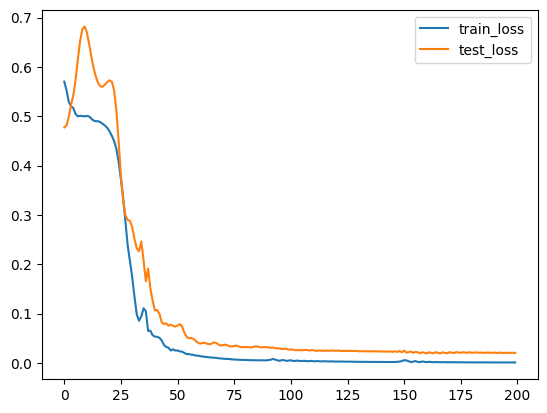

In [26]:
plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.show()

In [27]:
# one-step forecasting
validation_target = Y[-N // 2 :]
validation_predictions = []

# index for the first validation input 
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = x_test[i].reshape(1, T, 1)
    p = model(input_)[0,0].item()
    i += 1
    
    # update the prediction list
    validation_predictions.append(p)

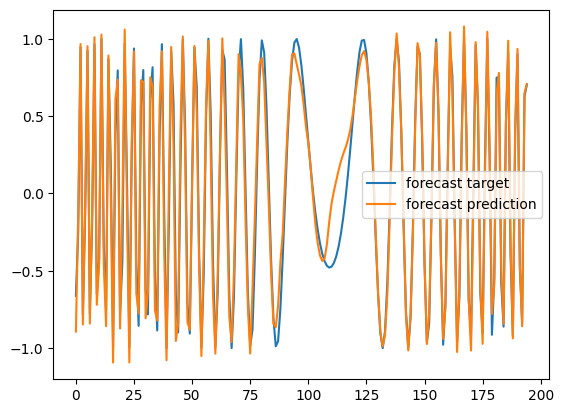

In [28]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()
plt.show()

In [29]:
# multi-step forecasting
validation_target = Y[-N // 2 :]
validation_predictions = []

# last_x = torch.from_numpy(X[-N // 2].astype(np.float32))
last_x = x_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.view(1, T, 1)
    p = model(input_)
    
    validation_predictions.append(p[0, 0].item())
    
    last_x = torch.cat((last_x[1 :], p[0]))

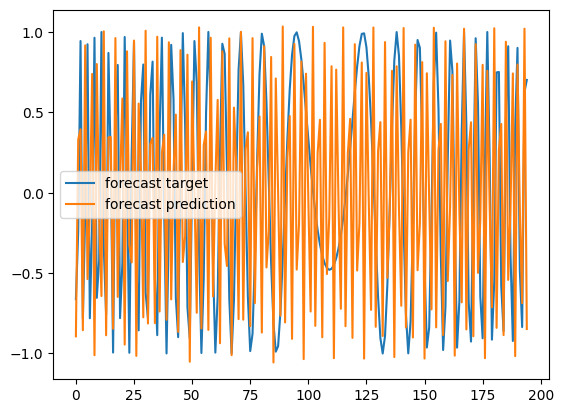

In [30]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()
plt.show()